In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import math
from scipy import signal
from scipy.fftpack import fft
from scipy import ndimage
from scipy import special
from scipy.io import loadmat
import math
import time as toc
import findiff
%matplotlib inline

In [2]:
## EqualState assign states with equal possibility for input array x
def EqualState(x, num_state):
    xs=np.sort(x)
    binlen=int(len(x)/num_state-0.5) #round
    edges = xs[np.arange(num_state+1)*binlen]
    xstate=np.zeros(len(x))
    for i in range(num_state):
        xstate[x>=edges[i]] = i
    xstate = xstate.astype(int)
    return xstate, edges

In [3]:
def Get_StimulusnResponse(ExporSim, conPar, par_list, IndParValue=1, channelnumber = 52):
    rstate_list = []
    if ExporSim=='Exp':
        x_list = []
        T_list = []
        if conPar=='Gramma':
            for G in par_list:
                annots = loadmat(exp_folder+'\\merge\\'+'merge_0224_OUsmooth_RL_G'+str(G)+'_5min_Q100_6.5mW_1Hz.mat')
                x = np.squeeze(annots['bin_pos'])
                x = x.astype(float)
                x = (x-np.mean(x))/np.std(x)
                T = np.squeeze(annots['diode_BT'])
                rstate, _ = np.histogram(annots['reconstruct_spikes'][0][channelnumber-1], np.append(0,T))
                rstate_list.append(rstate.copy())
                x_list.append( x.copy())
                T_list.append( T.copy())
            dt = 1/60
        elif conPar=='Fc':
            for Fc in par_list:
                exp_folder = 'D:\\GoogleDrive\\retina\\Exps\\2020\\0729'
                annots = loadmat(exp_folder+'\\merge\\'+'merge_0727_OUsmooth_Bright_UL_DR_G4.5_5min_Q100_6.5mW_'+str(Fc)+'Hz.mat')
                x = np.squeeze(annots['bin_pos'])
                x = x.astype(float)
                x = (x-np.mean(x))/np.std(x)
                T = np.squeeze(annots['diode_BT'])
                rstate, _ = np.histogram(annots['reconstruct_spikes'][0][channelnumber-1], np.append(0,T))
                rstate_list.append(rstate.copy())
                x_list.append( x.copy())
                T_list.append( T.copy())
        dt = 1/60
    else:    ##'Sim':
        if conPar=='Tau':
            Tot=300
            dt=1./60
            T=np.arange(dt,Tot,dt)
            # OU ; input
            tau= 0.1
            D = 27*10**5
            OU=np.zeros(len(T))
            mu, sigma = 0, 1
            cutoffFreq = IndParValue
            for tau in par_list:
                for i in range(len(T)-1):
                    OU[i+1]=OU[i]*(1-dt/tau)+math.sqrt(D*dt)*np.random.normal(mu,sigma)
                # filtering for OUSmoothed
                LPOU_list = []
                b, a = signal.butter(2, 2*cutoffFreq*dt, btype='low', analog=False)
                LPOU_list.append(signal.filtfilt(b, a, OU))
            x_list = LPOU_list.copy()  ##HMM or OU or LPOU
        elif conPar=='Fc':
            Tot=300
            dt=1./60
            T=np.arange(dt,Tot,dt)
            # OU ; input
            tau= IndParValue
            D = 27*10**5
            OU=np.zeros(len(T))
            mu, sigma = 0, 1
            for i in range(len(T)-1):
                OU[i+1]=OU[i]*(1-dt/tau)+math.sqrt(D*dt)*np.random.normal(mu,sigma)
            # filtering for OUSmoothed
            LPOU_list = []
            for cutoffFreq in par_list:
                b, a = signal.butter(2, 2*cutoffFreq*dt, btype='low', analog=False)
                LPOU_list.append(signal.filtfilt(b, a, OU))
            x_list = LPOU_list.copy()  ##HMM or OU or LPOU
        T_list = [T]*len(par_list)
    return x_list, T_list, dt, rstate_list


In [4]:
x_list, T_list, dt, rstate_list = Get_StimulusnResponse('Exp', 'Fc', [0.5,1,2,4,8,0],_, 52)

In [21]:
#assign states
x = x_list[0]
x = x.astype(float)
# x = (x-np.mean(x))/np.std(x)
v = ndimage.gaussian_filter1d(x.copy(), sigma=1, order=1, mode='wrap') / dt
v2 = findiff.FinDiff(0, dt, acc=4)(x)
coefs = findiff.coefficients(deriv=1, acc=4)
v3 = np.correlate(x,coefs['center']['coefficients'],'same')/dt
xstate, _= EqualState(x[1:], 6)
vstate, _= EqualState(v[1:], 6)
v2state, _= EqualState(v2[1:], 6)
v3state, _= EqualState(v3[1:], 6)

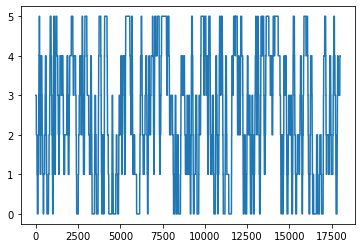

In [22]:
plt.plot(xstate)

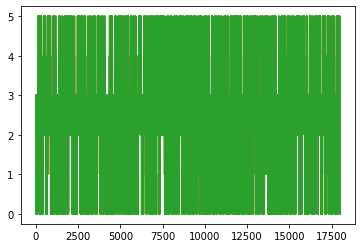

In [23]:
plt.plot(vstate)
plt.plot(v2state)
plt.plot(v3state)

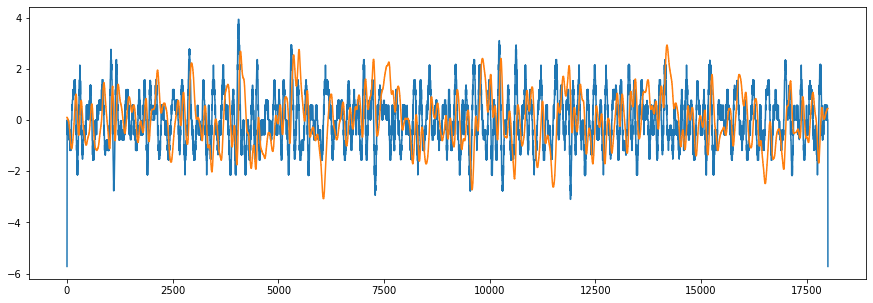

In [24]:

plt.plot(v/np.std(v))
plt.plot(x/np.std(x))
# plt.plot(v2)
# plt.plot(v3)
# plt.xlim([2000,2100])
plt.gcf().set_size_inches(15, 5)

In [39]:
coefs = findiff.coefficients(deriv=1, acc=20)

In [40]:
coefs['center']['coefficients']

array([ 5.41254377e-07, -1.20278749e-05,  1.28547911e-04, -8.81471367e-04,
        4.37062874e-03, -1.67832137e-02,  5.24475397e-02, -1.39860092e-01,
        3.40908917e-01, -9.09090256e-01, -1.04297599e-06,  9.09091590e-01,
       -3.40909290e-01,  1.39860199e-01, -5.24475701e-02,  1.67832216e-02,
       -4.37063046e-03,  8.81471666e-04, -1.28547949e-04,  1.20278781e-05,
       -5.41254505e-07])

In [41]:
v3 = np.correlate(x,coefs['center']['coefficients'],'same')/dt

In [54]:
v2 == v3

array([False, False, False, ..., False, False, False])